In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [2]:
#https://towardsdatascience.com/protein-sequence-classification-99c80d0ad2df refference
#https://www.kaggle.com/code/ismailyc/my-pfam-solution

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls /content/drive/MyDrive/Pactera/2022-04-12-log-datasets

model1.png  output_win10.txt  output_win11.txt


In [8]:
win10_file=open("/content/drive/MyDrive/Pactera/2022-04-12-log-datasets/output_win10.txt", "r")
win11_file=open("/content/drive/MyDrive/Pactera/2022-04-12-log-datasets/output_win11.txt", "r")

In [9]:
win10_data=win10_file.read()
win11_data=win11_file.read()

In [10]:
win10_tokens = list(win10_data.lower().split())
win11_tokens=list(win11_data.lower().split())
win10_token_size=len(win10_tokens)
win11_token_size=len(win11_tokens)
print(f"win10 token size is:{win10_token_size}")
print(f"win11 token size is:{win11_token_size}")

win10 token size is:303301
win11 token size is:140128


In [11]:
print(win10_tokens[:50])
print(win11_tokens[:50])

['getstartupinfow_*', 'getstartupinfow_ok', 'getstdhandle_*', 'getstdhandle_fail', 'getstdhandle_*', 'getstdhandle_fail', 'getstdhandle_*', 'getstdhandle_fail', 'getenvironmentstringsw_*', 'getenvironmentstringsw_ok', 'freeenvironmentstringsa_*', 'freeenvironmentstringsa_ok', 'getcommandlinea_*', 'getcommandlinea_ok', 'getcommandlinew_*', 'getcommandlinew_ok', 'getcpinfo_*', 'getcpinfo_ok', 'multibytetowidechar_*', 'multibytetowidechar_ok', 'multibytetowidechar_*', 'multibytetowidechar_ok', 'getstringtypew_*', 'getstringtypew_ok', 'multibytetowidechar_*', 'multibytetowidechar_ok', 'multibytetowidechar_*', 'multibytetowidechar_ok', 'lcmapstringw_*', 'lcmapstringw_ok', 'lcmapstringw_*', 'lcmapstringw_ok', 'multibytetowidechar_*', 'multibytetowidechar_ok', 'multibytetowidechar_*', 'multibytetowidechar_ok', 'lcmapstringw_*', 'lcmapstringw_ok', 'lcmapstringw_*', 'lcmapstringw_ok', 'encodepointer_*', 'encodepointer_ok', 'getsystemtimeasfiletime_*', 'getsystemtimeasfiletime_ok', 'encodepointe

In [12]:
total_tokens=[*win10_tokens, *win11_tokens]

In [13]:
total_vocab, index = {}, 1  # start indexing from 1
total_vocab['<pad>'] = 0  # add a padding token
freqency_dict={}
for token in total_tokens:
  if token not in total_vocab:
    freqency_dict[token]=1
    total_vocab[token] = index
    index += 1
  else:
    freqency_dict[token]+=1
total_vocab_size = len(total_vocab)


print(total_vocab)

{'<pad>': 0, 'getstartupinfow_*': 1, 'getstartupinfow_ok': 2, 'getstdhandle_*': 3, 'getstdhandle_fail': 4, 'getenvironmentstringsw_*': 5, 'getenvironmentstringsw_ok': 6, 'freeenvironmentstringsa_*': 7, 'freeenvironmentstringsa_ok': 8, 'getcommandlinea_*': 9, 'getcommandlinea_ok': 10, 'getcommandlinew_*': 11, 'getcommandlinew_ok': 12, 'getcpinfo_*': 13, 'getcpinfo_ok': 14, 'multibytetowidechar_*': 15, 'multibytetowidechar_ok': 16, 'getstringtypew_*': 17, 'getstringtypew_ok': 18, 'lcmapstringw_*': 19, 'lcmapstringw_ok': 20, 'encodepointer_*': 21, 'encodepointer_ok': 22, 'getsystemtimeasfiletime_*': 23, 'getsystemtimeasfiletime_ok': 24, 'decodepointer_*': 25, 'decodepointer_ok': 26, 'isprocessorfeaturepresent_*': 27, 'isprocessorfeaturepresent_ok': 28, 'initializeslisthead_*': 29, 'initializeslisthead_ok': 30, 'initializecriticalsectionandspincount_*': 31, 'initializecriticalsectionandspincount_ok': 32, 'getmodulehandlew_*': 33, 'getmodulehandlew_ok': 34, 'notwindowapi_ok': 35, 'initoncei

In [14]:
print(len(total_vocab))

390


In [15]:
#print the dict[:10]
first_10_items = {k: freqency_dict[k] for k in list(freqency_dict)[:10]}
first_10_items

{'freeenvironmentstringsa_*': 2,
 'freeenvironmentstringsa_ok': 2,
 'getcommandlinea_*': 4,
 'getcommandlinea_ok': 4,
 'getenvironmentstringsw_*': 4,
 'getenvironmentstringsw_ok': 4,
 'getstartupinfow_*': 6,
 'getstartupinfow_ok': 6,
 'getstdhandle_*': 12,
 'getstdhandle_fail': 12}

In [16]:
max_key=max(freqency_dict, key=freqency_dict.get)
freqency_dict[max_key]

67759

In [17]:
win10_freqency_df=pd.DataFrame(data=freqency_dict, index=["seq_char_count"])

In [18]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns
%matplotlib inline

In [19]:
win10_freqency_df=win10_freqency_df.T

In [20]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


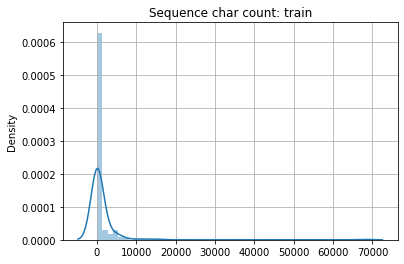

In [21]:
plot_seq_count(win10_freqency_df, "train")

In [22]:
#we only need the fix-length sequence in tranning in this version.
'''
def create_random_number_range_seqence_lenth_generator(min, max, token_number):
  rand_list=[]
  total_number=token_number
  while(total_number>0):
    rand_value=random.randrange(min, max)
    total_number-=rand_value
    if total_number<0:
      rand_list.append(0-total_number)
    else:
      rand_list.append(rand_value)
  return rand_list
'''

'\ndef create_random_number_range_seqence_lenth_generator(min, max, token_number):\n  rand_list=[]\n  total_number=token_number\n  while(total_number>0):\n    rand_value=random.randrange(min, max)\n    total_number-=rand_value\n    if total_number<0:\n      rand_list.append(0-total_number)\n    else:\n      rand_list.append(rand_value)\n  return rand_list\n'

In [23]:
'''
import random
def generate_random_length_list(min, max , total_token_number):
  r_list=[]
  num=total_token_number
  while num>0:
    randnum=random.randrange(min, max)
    num-=randnum
    if num<0:
      r_list.append(num)
    r_list.append(randnum)
  return r_list
'''

'\nimport random\ndef generate_random_length_list(min, max , total_token_number):\n  r_list=[]\n  num=total_token_number\n  while num>0:\n    randnum=random.randrange(min, max)\n    num-=randnum\n    if num<0:\n      r_list.append(num)\n    r_list.append(randnum)\n  return r_list\n'

In [24]:
'''
MIN_GET_TOKEN_NUMBER=3
MAX_GET_TOKEN_NUMBER=100


win10_rand_len_list=generate_random_length_list(MIN_GET_TOKEN_NUMBER, MAX_GET_TOKEN_NUMBER,win10_token_size)
print(win10_rand_len_list[:10])

win11_rand_len_list=generate_random_length_list(MIN_GET_TOKEN_NUMBER, MAX_GET_TOKEN_NUMBER, win11_token_size)
print(win11_rand_len_list[:11])
'''

'\nMIN_GET_TOKEN_NUMBER=3\nMAX_GET_TOKEN_NUMBER=100\n\n\nwin10_rand_len_list=generate_random_length_list(MIN_GET_TOKEN_NUMBER, MAX_GET_TOKEN_NUMBER,win10_token_size)\nprint(win10_rand_len_list[:10])\n\nwin11_rand_len_list=generate_random_length_list(MIN_GET_TOKEN_NUMBER, MAX_GET_TOKEN_NUMBER, win11_token_size)\nprint(win11_rand_len_list[:11])\n'

In [25]:
'''
from tensorflow.keras.preprocessing.sequence import pad_sequences
#tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=None,dtype='int32',padding='pre',
def integer_encoding(tokens, vocab, randlist):  
  encode_list_of_list = []
  encode_list=[]
  target_list=[]
  count=0
  total_count=0
  the_length_list_index_count=0
  for token in tokens:
    get_n_token_number=randlist[the_length_list_index_count]
    token_encode= vocab[token]
    encode_list.append(token_encode)
    count+=1
    total_count+=1
    #next_token_index+=1
    #note, it have to be len(SEQ)+1 cause the last number will be the label.
    if count==get_n_token_number:
      #create predict target list
      target=tokens[total_count]
      encode_target=vocab[target]
      target_list.append(encode_target)

      encode_list_of_list.append(np.array(encode_list))
      encode_list=[]
      count=0
  return encode_list_of_list, target_list
'''

"\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\n#tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=None,dtype='int32',padding='pre',\ndef integer_encoding(tokens, vocab, randlist):  \n  encode_list_of_list = []\n  encode_list=[]\n  target_list=[]\n  count=0\n  total_count=0\n  the_length_list_index_count=0\n  for token in tokens:\n    get_n_token_number=randlist[the_length_list_index_count]\n    token_encode= vocab[token]\n    encode_list.append(token_encode)\n    count+=1\n    total_count+=1\n    #next_token_index+=1\n    #note, it have to be len(SEQ)+1 cause the last number will be the label.\n    if count==get_n_token_number:\n      #create predict target list\n      target=tokens[total_count]\n      encode_target=vocab[target]\n      target_list.append(encode_target)\n\n      encode_list_of_list.append(np.array(encode_list))\n      encode_list=[]\n      count=0\n  return encode_list_of_list, target_list\n"

In [159]:
#drop the last sequence less than the max_seq size
MAX_SEQUENCE_LENGTH=100
def generate_the_fix_length_encoded_sequence_and_target(tokens, vocab):
  encode_list_of_list = []
  encode_list=[]
  target_list=[]

  token_length=len(tokens)
  sequence_number=int(token_length/MAX_SEQUENCE_LENGTH)
  count=0
  counter_of_sequence_number=0
  for  token in tokens:

    #index from 0, so the max length need to -1.
    encode_list.append(vocab[token])
    count+=1

    if count % (MAX_SEQUENCE_LENGTH)==0: 
      encode_list_of_list.append(encode_list)
      predict_token=tokens[count+1]
      target_list.append(vocab[predict_token])
      encode_list=[]
      counter_of_sequence_number+=1
    if counter_of_sequence_number==sequence_number-1:
      break
    

  #drop_the_last_list_anyway
  #encode_list_of_list=encode_list_of_list[:-1]
  return encode_list_of_list, target_list


  

In [160]:
win10_encode_list_of_list, win10_target_list = generate_the_fix_length_encoded_sequence_and_target(win10_tokens, total_vocab)
win11_encode_list_of_list, win11_target_list = generate_the_fix_length_encoded_sequence_and_target(win11_tokens, total_vocab)

In [161]:
print(len(win11_encode_list_of_list))
print(len(win10_encode_list_of_list))

1400
3032


In [162]:
'''
SEQENCE_LENGTH=100
#pad sequence with 0 until the length== SEQUENCE LENGTH
win10_encode_list_of_list=pad_sequences(win10_encode_list_of_list,maxlen=SEQENCE_LENGTH,padding='post',value=0)
win11_encode_list_of_list=pad_sequences(win11_encode_list_of_list,maxlen=SEQENCE_LENGTH,padding='post',value=0)
'''

"\nSEQENCE_LENGTH=100\n#pad sequence with 0 until the length== SEQUENCE LENGTH\nwin10_encode_list_of_list=pad_sequences(win10_encode_list_of_list,maxlen=SEQENCE_LENGTH,padding='post',value=0)\nwin11_encode_list_of_list=pad_sequences(win11_encode_list_of_list,maxlen=SEQENCE_LENGTH,padding='post',value=0)\n"

In [163]:
print(win10_encode_list_of_list[:3])
print(len(win10_encode_list_of_list[0]))

[[1, 2, 3, 4, 3, 4, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 15, 16, 17, 18, 15, 16, 15, 16, 19, 20, 19, 20, 15, 16, 15, 16, 19, 20, 19, 20, 21, 22, 23, 24, 21, 22, 25, 26, 25, 26, 21, 22, 21, 22, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 27, 28, 40, 41, 36, 37, 38, 39, 40, 41, 40, 41, 33, 34, 35, 42, 43, 44, 35, 31, 32, 31, 32, 31, 32, 45, 46, 35, 47, 48, 49, 50, 47], [48, 49, 50, 47, 48, 29, 30, 29, 30, 29, 30, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 27, 28, 36, 37, 38, 39, 36, 37, 38, 39, 36, 37, 38, 39, 33, 34, 35, 51, 52, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51], [53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51, 53, 51,

In [164]:
#not used for now
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[-1]
    return input_text,target_text

In [165]:
print(len(win10_encode_list_of_list[0]))
print(len(win10_encode_list_of_list[-1]))


100
100


In [166]:
BATCH_SIZE=1
total_data=np.reshape(win10_encode_list_of_list,(len(win10_encode_list_of_list),MAX_SEQENCE_LENGTH,BATCH_SIZE))
#total_data=np.reshape(win10_encode_list_of_list,(30,100,1))
valid_data=np.reshape(win11_encode_list_of_list,(len(win11_encode_list_of_list),MAX_SEQENCE_LENGTH,BATCH_SIZE))

In [167]:
from tensorflow.keras.utils import to_categorical

total_target_ohe=to_categorical(win10_target_list, num_classes=total_vocab_size)
valid_target_ohe=to_categorical(win11_target_list, num_classes=total_vocab_size)

In [168]:
print(total_data.shape)
print(valid_data.shape)
print(total_target_ohe.shape)
print(valid_target_ohe.shape)

(3032, 100, 1)
(1400, 100, 1)
(3032, 390)
(1400, 390)


In [169]:
total_data

array([[[  1],
        [  2],
        [  3],
        ...,
        [ 49],
        [ 50],
        [ 47]],

       [[ 48],
        [ 49],
        [ 50],
        ...,
        [ 51],
        [ 53],
        [ 51]],

       [[ 53],
        [ 51],
        [ 53],
        ...,
        [ 51],
        [ 53],
        [ 51]],

       ...,

       [[271],
        [272],
        [273],
        ...,
        [272],
        [273],
        [274]],

       [[271],
        [272],
        [273],
        ...,
        [ 88],
        [271],
        [272]],

       [[273],
        [274],
        [271],
        ...,
        [226],
        [ 84],
        [ 88]]])

In [289]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import Sequential


'''
x_input = Input(shape=(total_data.shape[1], total_data.shape[2]))
emb = Embedding(21, 128, input_length=SEQENCE_LENGTH)(x_input)
bi_rnn = Bidirectional(LSTM(64, kernel_regularizer=L2(0.01), recurrent_regularizer=L2(0.01), bias_regularizer=L2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(100, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(win10_vocab_size, 128,
     batch_input_shape=[batch_size, None]))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],run_eagerly=True)
print(model1.summary())

model1 = tf.keras.Sequential([
     tf.keras.layers.Embedding(win10_vocab_size, 128,
     batch_input_shape=[batch_size, None]),
#    tf.keras.layers.BatchNormalization(),
#        tf.keras.layers.Dropout(0.2),
                tf.keras.layers.GRU(256,
     return_sequences=True,
     stateful=True,
     recurrent_initializer='glorot_uniform'),
    tf.keras.layers.GRU(256,
     return_sequences=True,
     stateful=True,
     recurrent_initializer='glorot_uniform'),
     tf.keras.layers.Dense(win10_vocab_size),
 ])
'''

model=Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(total_data.shape[1], total_data.shape[2])))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.1))
model.add(Dense(total_target_ohe.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])




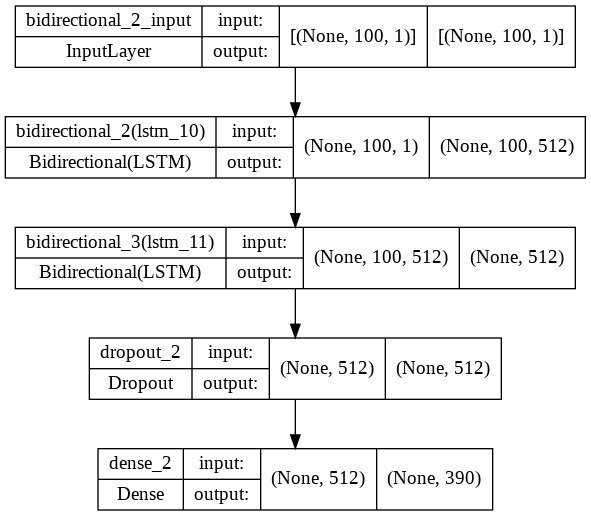

In [290]:
tf.keras.utils.plot_model(
    model, to_file='/content/drive/MyDrive/Pactera/2022-04-12-log-datasets/model1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [291]:
!ls ./drive/MyDrive/Pactera/deep_learning_trainning_weight

checkpoint		     ckpt_21.index
ckpt_10.data-00000-of-00001  ckpt_22.data-00000-of-00001
ckpt_10.index		     ckpt_22.index
ckpt_11.data-00000-of-00001  ckpt_23.data-00000-of-00001
ckpt_11.index		     ckpt_23.index
ckpt_12.data-00000-of-00001  ckpt_24.data-00000-of-00001
ckpt_12.index		     ckpt_24.index
ckpt_13.data-00000-of-00001  ckpt_25.data-00000-of-00001
ckpt_13.index		     ckpt_25.index
ckpt_14.data-00000-of-00001  ckpt_2.data-00000-of-00001
ckpt_14.index		     ckpt_2.index
ckpt_15.data-00000-of-00001  ckpt_3.data-00000-of-00001
ckpt_15.index		     ckpt_3.index
ckpt_16.data-00000-of-00001  ckpt_4.data-00000-of-00001
ckpt_16.index		     ckpt_4.index
ckpt_17.data-00000-of-00001  ckpt_5.data-00000-of-00001
ckpt_17.index		     ckpt_5.index
ckpt_18.data-00000-of-00001  ckpt_6.data-00000-of-00001
ckpt_18.index		     ckpt_6.index
ckpt_19.data-00000-of-00001  ckpt_7.data-00000-of-00001
ckpt_19.index		     ckpt_7.index
ckpt_1.data-00000-of-00001   ckpt_8.data-00000-of-00001
ckpt_1.index		 

In [292]:


checkpoint_dir="./drive/MyDrive/Pactera/deep_learning_trainning_weight"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:

history =model.fit(total_data,total_target_ohe, epochs=30, batch_size=1, callbacks=[checkpoint_callback], validation_data=(valid_data, valid_target_ohe), verbose=2)

Epoch 1/30


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [177]:
model.save_weights(checkpoint_dir)

In [276]:
def verification( from_num , test_number ,sequence_len):
  temperature=1
  predict_result=[]
  for i in range(0,test_number):
    input_str=[ total_vocab[x] for x in win11_tokens[from_num + i : from_num + sequence_len + i]]
    logist=model.predict(tf.expand_dims(input_str,0))

    prediction = tf.nn.softmax(logist)
    #shape=(1, 390)
    #prediction=logist
    prediction = prediction / temperature
    predicted_id = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
    print(prediction[0, predicted_id])
    predict_result.append(win11_tokens[predicted_id])
  return predict_result
  


In [277]:
result= verification(130,50,100)


tf.Tensor(0.00255332, shape=(), dtype=float32)
tf.Tensor(0.0025528986, shape=(), dtype=float32)
tf.Tensor(0.0025532627, shape=(), dtype=float32)
tf.Tensor(0.0025529005, shape=(), dtype=float32)
tf.Tensor(0.0025529666, shape=(), dtype=float32)
tf.Tensor(0.0025531757, shape=(), dtype=float32)
tf.Tensor(0.0025534618, shape=(), dtype=float32)
tf.Tensor(0.0025530525, shape=(), dtype=float32)
tf.Tensor(0.002553275, shape=(), dtype=float32)
tf.Tensor(0.002553053, shape=(), dtype=float32)
tf.Tensor(0.0025532742, shape=(), dtype=float32)
tf.Tensor(0.002553053, shape=(), dtype=float32)
tf.Tensor(0.0025532742, shape=(), dtype=float32)
tf.Tensor(0.002553053, shape=(), dtype=float32)
tf.Tensor(0.0025532742, shape=(), dtype=float32)
tf.Tensor(0.002553053, shape=(), dtype=float32)
tf.Tensor(0.0025532742, shape=(), dtype=float32)
tf.Tensor(0.002553053, shape=(), dtype=float32)
tf.Tensor(0.0025532742, shape=(), dtype=float32)
tf.Tensor(0.002553053, shape=(), dtype=float32)
tf.Tensor(0.0025532742, shape

In [274]:
result

['isdbcsleadbyte_*',
 'getsystemtimeasfiletime_*',
 'isdbcsleadbyte_*',
 'cotaskmemalloc_*',
 'isdbcsleadbyte_ok',
 'initializeconditionvariable_ok',
 'initializeconditionvariable_*',
 'isdbcsleadbyte_*',
 'initializecriticalsectionex_*',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_*',
 'initializeslisthead_*',
 'getcommandlinew_ok',
 'isdbcsleadbyte_*',
 'getstartupinfow_ok',
 'lcmapstringw_ok',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_ok',
 'notwindowapi_*',
 'freeenvironmentstringsa_ok',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_ok',
 'initializecriticalsectionex_*',
 'initializecriticalsectionandspincount_*',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_*',
 'getcurrentprocess_*',
 'notwindowapi_ok',
 'getcommandlinea_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_*',
 'multibytetowidechar_*',
 'getcurrentprocess_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte

In [275]:
win11_tokens[130:180]

['initonceinitialize_*',
 'initializeconditionvariable_*',
 'initializeconditionvariable_ok',
 'initonceinitialize_ok',
 'getmodulehandlew_*',
 'getmodulehandlew_ok',
 'notwindowapi_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_fail',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte_ok',
 'isdbcsleadbyte_*',
 'isdbcsleadbyte

In [273]:
input_str=[ total_vocab[x] for x in win11_tokens[1:101]]

In [213]:
len(input_str)

100

In [214]:
input_str

[2,
 3,
 4,
 3,
 4,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 15,
 16,
 17,
 18,
 15,
 16,
 15,
 16,
 19,
 20,
 19,
 20,
 15,
 16,
 15,
 16,
 19,
 20,
 19,
 20,
 21,
 22,
 23,
 24,
 21,
 22,
 25,
 26,
 25,
 26,
 21,
 22,
 21,
 22,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 27,
 28,
 40,
 41,
 40,
 41,
 40,
 41,
 36,
 37,
 38,
 39,
 33,
 34,
 35,
 42,
 43,
 44,
 35,
 31,
 32,
 31,
 32,
 31,
 32,
 45,
 46,
 35,
 47,
 48,
 49,
 50,
 47,
 48,
 49,
 50,
 47,
 48]

In [217]:
logist=model.predict(tf.expand_dims(input_str,0))
logist

array([[9.51885326e-09, 1.00192059e-08, 7.64100161e-09, 1.32850948e-08,
        8.51638582e-09, 1.46771271e-08, 9.11497278e-09, 9.72512737e-09,
        1.12584733e-08, 1.00044639e-08, 1.46651500e-08, 1.05809370e-08,
        8.68523387e-09, 9.05835140e-09, 8.10308265e-09, 2.55375053e-03,
        9.15946788e-04, 8.04946065e-09, 1.65721801e-08, 1.06860769e-08,
        9.00527564e-09, 1.46003524e-02, 4.13034678e-01, 1.24055521e-08,
        1.04951523e-08, 1.23970538e-01, 2.85892226e-02, 7.39488915e-09,
        8.15029733e-09, 9.56165103e-09, 8.57609539e-09, 7.88819860e-04,
        1.33800242e-08, 9.62277724e-09, 7.69295916e-09, 1.16854010e-03,
        1.00532604e-08, 7.36669170e-09, 7.93475419e-09, 1.03370716e-08,
        1.24177202e-08, 1.25590649e-08, 6.81956358e-09, 8.69151506e-09,
        9.41025213e-09, 8.18308621e-09, 9.33661148e-09, 1.61439448e-08,
        7.71478081e-09, 3.07003289e-01, 1.08341300e-08, 7.49399215e-02,
        1.30156952e-08, 1.33920244e-08, 1.04470592e-08, 9.591533

In [262]:
        temperature=1
        #prediction = tf.nn.softmax(logist)
        prediction = prediction / temperature
        predicted_id = tf.random.categorical(prediction, num_samples=1)[-1,0].numpy()
        

In [219]:
predicted_id

346

In [222]:
win11_tokens[102]

'initializeslisthead_ok'

In [223]:
win11_tokens[346]

'isdbcsleadbyte_ok'